In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Об эксперименте
Гипотезы, на что мог повлиять эксперимент:
1. Конверсия в разовое пожертвование - пользователя не отталкивает предустановленная сумма и он охотнее делает пожертвование 
2. Средняя сумма пожертвования - как разового, так и на платящего пользователя или просто на пользователя. В нашем случае корректнее смотреть среднюю сумму пожертвования на пользователя (ARPU), так как сумма одного пожертвования может снизиться, но за счет роста конверсии доход с пользователя вырастет
Как следствие из предыдущих пунктов, конверсию можно не считать, так как ее динамика уже заложена в ARPU, но при этом подсчете большего числа метрик придется делать поправки на множественное сравнение, что снизит мощность эксперимента. В целом по результатам эксперимента стоит посмотреть и ARPPU, и конверсию в разовый платеж, но скорее для генерации инсайтов, и не считать по ним статзначимость и не делать поправки на МПГ
3. Кажется, что прирост конверсии и ARPU с разового платежа не обязательно приведет к росту выручки в целом, так как это может быть следствием каннибализации пользователей, которые могли бы оформить подписку на донации. Поэтому в качестве гардрейл метрики надо добавить конверсию в подписку на донации - она не должна упасть

Далее посмотрим, что за данные вообще есть в наличии

In [2]:
df = pd.read_csv('test.csv')
df

,ClientID,EventTime,EventType,DonationType,AmountInUSD,tag
0,885410877,2022-07-20 00:00:23,checkoutView,NaN,NaN,control
1,859319263,2022-07-20 00:00:48,checkoutView,NaN,NaN,test
2,480984859,2022-07-20 00:00:58,checkoutView,NaN,NaN,control
3,204664871,2022-07-20 00:01:00,checkoutView,NaN,NaN,test
4,859319263,2022-07-20 00:01:05,checkoutView,NaN,NaN,test
...,...,...,...,...,...,...
58765,244210529,2022-07-27 00:00:12,charge,one-time,62.0,NaN
58766,920234036,2022-07-27 00:02:47,charge,one-time,110.0,NaN
58767,450325260,2022-07-27 00:03:55,charge,one-time,32.0,NaN
58768,450325260,2022-07-27 00:04:09,checkoutView,NaN,NaN,control


Сразу видны пропуски в названиях группы. Они встречаются у событий типа charge. Соответственно, надо преобразовать датафрейм

In [3]:
df[df['DonationType'].isna()]['EventType'].drop_duplicates()

0    checkoutView
Name: EventType, dtype: object

Выше проверил на наличие технических ошибок из формата что в событии charge почему-то не проставился donationType и как следствие нельзя нормально посчитать конверсию

In [4]:
df[df['AmountInUSD'].isna()]['EventType'].drop_duplicates()

0    checkoutView
Name: EventType, dtype: object

Аналогично проверил для суммы пожертвований, что можно нормально считать денежные метрики

In [5]:
df_funnel = pd.merge(
    df[df['EventType'] == 'checkoutView'].groupby(['ClientID', 'tag'], as_index=False).agg({'EventTime':'min'}),
    df[df['EventType'] == 'charge'].groupby(['ClientID', 'DonationType'], as_index=False).agg({'EventTime':'min', 'AmountInUSD':'sum'}),
    how='left',
    on='ClientID'
)
df_funnel

,ClientID,tag,EventTime_x,DonationType,EventTime_y,AmountInUSD
0,100015892,test,2022-07-25 12:25:05,NaN,NaN,NaN
1,100032769,test,2022-07-25 19:52:33,NaN,NaN,NaN
2,100062684,test,2022-07-23 23:43:11,NaN,NaN,NaN
3,100085444,test,2022-07-25 02:33:12,one-time,2022-07-25 02:36:02,10.0
4,100140690,control,2022-07-20 14:24:17,NaN,NaN,NaN
...,...,...,...,...,...,...
42256,999815194,test,2022-07-21 04:20:07,NaN,NaN,NaN
42257,999823250,test,2022-07-22 19:12:32,NaN,NaN,NaN
42258,999827499,test,2022-07-24 18:31:41,NaN,NaN,NaN
42259,999962363,test,2022-07-21 21:55:15,NaN,NaN,NaN


Проверим, что лишнего не отфильтровал и не задублировал

In [6]:
df['ClientID'].nunique() == df_funnel['ClientID'].nunique()

True

In [7]:
df['AmountInUSD'].sum() == df_funnel['AmountInUSD'].sum()

True

Теперь заполняю пропуски, делаю вычисляемые поля

In [8]:
df_funnel.loc[df_funnel['DonationType'] == 'one-time', 'has_donation_one_time'] = 1
df_funnel.loc[df_funnel['DonationType'] == 'recurring', 'has_donation_recurring'] = 1

In [9]:
df_funnel.loc[df_funnel['DonationType'] == 'one-time', 'ARPU_one_time'] = df_funnel.loc[df_funnel['DonationType'] == 'one-time', 'AmountInUSD']

In [10]:
df_funnel.fillna(0, inplace=True)

### Метрики
В итоге можем корректно посчитать и буду считать следующие метрики:
1. ARPU разового платежа (не учитываю сумму с подписок на донации, так как там скорее речь про LTV, который посчитать на этих данных нельзя)
2. Гардрейл метрика - конверсия в подписку на донации

Перейдем к самим данным и посмотрим, какие критерии можно применить

In [11]:
df_funnel.groupby('tag').agg({'has_donation_recurring':'mean', 'ARPU_one_time':'mean'})

,has_donation_recurring,ARPU_one_time
tag,,
control,0.004917,9.411025
test,0.003363,10.101805


Видно, что метрика ARPU достаточно сильно выросла, в то время как гардрейл метрика упала. Если про гардрейл метрику говорить особо нечего (она биноминальная), то метрика ARPU непрерывная и ее надо изучить на наличие выбросов и в целом посмотреть ее распределение

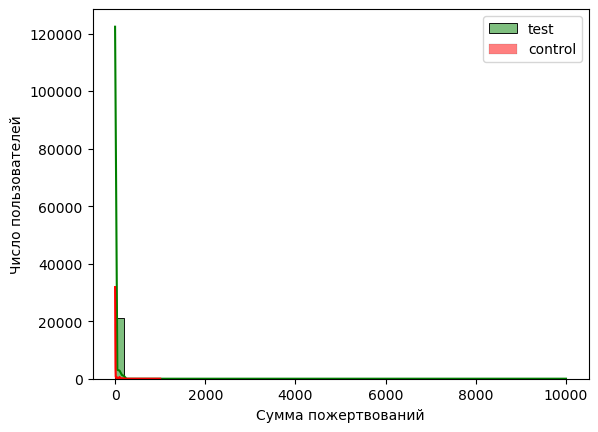

In [12]:
sns.histplot(data=df_funnel.loc[df_funnel['tag'] == 'test'], x='ARPU_one_time', color="green", label='test', kde=True, bins=50)
sns.histplot(data=df_funnel.loc[df_funnel['tag'] == 'control'], x='ARPU_one_time', color="red", label='control', kde=True, bins=50)

plt.ylabel('Число пользователей')
plt.xlabel('Сумма пожертвований')
plt.legend() 
plt.show()

На гистограмме виден большой хвост. Следовательно в таком виде через т-критерий метрику оценивать нельзя. Так как выше видно, что среднее в тестовой группе действительно выше контрольной, то можно использовать критерий Манна-Уитни (как минимум это исключает случай, когда по Манну-Уитни есть прирост, а прироста средней на самом деле нет)

Итого:
1. Для ARPU используем Манна-Уитни
2. Для конверсии в подписку на донации используем t-test

### Аб-тест

In [13]:
from scipy.stats import mannwhitneyu, ttest_ind

In [14]:
alpha = 0.05
num_metrics = 2
alpha_corrected = alpha/num_metrics #Применяю поправку Бонферони 

res = []

p_val = mannwhitneyu(
    df_funnel.loc[df_funnel['tag'] == 'control', 'ARPU_one_time'],
    df_funnel.loc[df_funnel['tag'] == 'test', 'ARPU_one_time'], 
    alternative='two-sided'
)[1]
m1, m2 = df_funnel.loc[df_funnel['tag'] == 'control', 'ARPU_one_time'].mean(), df_funnel.loc[df_funnel['tag'] == 'test', 'ARPU_one_time'].mean()

metric = ['ARPU_one_time', m1, m2, m2/m1-1, p_val, p_val<=alpha_corrected]
res.append(metric)

In [15]:
p_val = ttest_ind(
    df_funnel.loc[df_funnel['tag'] == 'control', 'has_donation_recurring'],
    df_funnel.loc[df_funnel['tag'] == 'test', 'has_donation_recurring'], 
    alternative='two-sided', 
    equal_var=False
)[1]
m1, m2 = df_funnel.loc[df_funnel['tag'] == 'control', 'has_donation_recurring'].mean(), df_funnel.loc[df_funnel['tag'] == 'test', 'has_donation_recurring'].mean()

metric = ['has_donation_recurring', m1, m2, m2/m1-1, p_val, p_val<=alpha_corrected]
res.append(metric)

In [16]:
df_res = pd.DataFrame(res, columns=['metric', 'control', 'test', 'delta', 'p_value', 'is_significant'])
df_res

,metric,control,test,delta,p_value,is_significant
0,ARPU_one_time,9.411025,10.101805,0.073401,0.001955,True
1,has_donation_recurring,0.004917,0.003363,-0.315917,0.012892,True


Выводы:
1. С одной стороны, эксперимент статзначимо на 7.3% прирастил донации на пользователя разовых донаций
2. С другой стороны, на -31% упала конверсия в подписку на донации
В результате, эксперимент требует дополнительного изучения, так как кажется, что пользователи с подпиской ценнее разовых пользователей. Что можно было бы посмотреть:
1. Были ли технические ошибки в тестовой группе, может, некорректно работало переключение
2. Вообще такое падение выглядит странно, возможны ли параллельные эксперименты и изменения, которые могли повлиять на поведение пользователя? Точно ли корректно сплитовались пользователи, мб в разные группы попали пользователи с разным поведением 
3. А мы вообще набрали достаточную выборку, стабилизировался ли p_value? Быть может он не стабилизировался (это можно проверить на текущих данных)
4. Другие более детальные гипотезы по событиям или по портртету пользователей

### Проверка на стабилизацию p_value по метрике подписки на регулярные донации

In [17]:
df['EventTime'] = pd.to_datetime(df['EventTime'])
df['day'] = df['EventTime'].dt.day-19

pvals = []

for i in range(1, 9):
    df_temp = df[df['day'] <= i]
    df_check = pd.merge(
        df_temp[df_temp['EventType'] == 'checkoutView'].groupby(['ClientID', 'tag'], as_index=False).agg({'EventTime':'min'}),
        df_temp[df_temp['EventType'] == 'charge'].groupby(['ClientID', 'DonationType'], as_index=False).agg({'EventTime':'min', 'AmountInUSD':'sum'}),
        how='left',
        on='ClientID'
    )
    
    df_check.loc[df_check['DonationType'] == 'recurring', 'has_donation_recurring'] = 1
    df_check.fillna(0, inplace=True)
    
    p_val = ttest_ind(
        df_check.loc[df_check['tag'] == 'control', 'has_donation_recurring'],
        df_check.loc[df_check['tag'] == 'test', 'has_donation_recurring'], 
        alternative='two-sided', 
        equal_var=False
    )[1]
    
    pvals.append([i, p_val, df_check.loc[df_check['DonationType'] == 'recurring', 'ClientID'].nunique()])

df_pvals = pd.DataFrame(pvals, columns=['day', 'p_val', 'user_num_total'])

In [18]:
df_pvals

,day,p_val,user_num_total
0,1,0.297218,14
1,2,0.708926,45
2,3,0.311735,78
3,4,0.249761,102
4,5,0.016423,125
5,6,0.007901,146
6,7,0.012881,175
7,8,0.012892,175


In [19]:
p_val = ttest_ind(
    df_funnel.loc[df_funnel['tag'] == 'control', 'has_donation_recurring'],
    df_funnel.loc[df_funnel['tag'] == 'test', 'has_donation_recurring'], 
    alternative='two-sided', 
    equal_var=False
)[1]
p_val

0.012891732336358664

Уже 4 недели метрика держится на уровне менее 0.025 (альфа с поправкой), то есть гипотеза, что мы не набрали выборку, отбрасывается